In [1]:
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt

# Paths to the JSON files
file_paths = [
    r"C:\Users\PC\Downloads\json_thesis\mistral_events_mc_results_0_9900.json",
    r"C:\Users\PC\Downloads\json_thesis\mistral_events_mc_results_9901_19818.json"
]

# Define keywords for location and year questions for each language
location_keywords = {
    'EN': ["In which country did the event"],
    'FR': ["Dans quel pays a eu lieu l'événement"],
    'DE': ["In welchem Land fand das Ereignis "],
    'TR': [" olayı hangi ülkede gerçekleşti"],
    'JA': ["はどの国で行われましたか"]
}

year_keywords = {
    'EN': ["In which year did the event"],
    'FR': ["En quelle année l'événement"],
    'DE': ["In welchem Jahr fand das Ereignis"],
    'TR': ["olayı hangi yıl gerçekleşti"],
    'JA': ["は何年に行われましたか"]
}

# Function to load JSON file and convert to DataFrame
def load_json_to_df(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            data.append(json.loads(line))
    df = pd.DataFrame(data)
    return df

# Function to classify question type based on keywords
def get_question_type(question, language):
    if language not in location_keywords or language not in year_keywords:
        return "Other"
    
    for keyword in location_keywords[language]:
        if keyword.lower() in question.lower():
            return "Location"
    for keyword in year_keywords[language]:
        if keyword.lower() in question.lower():
            return "Year"
    return "Other"

# Initialize a DataFrame to store combined data
combined_df = pd.DataFrame()

# Load data from the JSON files
for file_path in file_paths:
    df = load_json_to_df(file_path)
    combined_df = pd.concat([combined_df, df], ignore_index=True)

# Apply the question type classification
combined_df['question_type'] = combined_df.apply(lambda row: get_question_type(row['Question'], row['Language']), axis=1)


In [2]:
combined_df

,Question,Options,Model_Answer,Correct_Letter,Compared_Answer,Time_Taken,Language,question_type
0,In which country did the event 'Battle of Whit...,"{'A': 'United States of America', 'B': 'Turkey...",Answer: A. The Battle of White Oak Swamp took ...,A,1,2.170176,EN,Location
1,In which country did the event 'Battle of Spri...,"{'A': 'United States of America', 'B': 'Japan'...",Answer: A. The Battle of Springfield took plac...,A,1,1.206063,EN,Location
2,In which country did the event 'Battle of la T...,"{'A': 'Turkey', 'B': 'United Kingdom', 'C': 'F...",Answer: C. The Battle of la Truyère took place...,C,1,1.102128,EN,Location
3,In which country did the event 'Battle of Miho...,"{'A': 'United Kingdom', 'B': 'France', 'C': 'J...",Answer: C. Japan.\n\nThe Battle of Mihonoseki ...,C,1,1.365414,EN,Location
4,In which country did the event 'Battle of Hang...,"{'A': 'United Kingdom', 'B': 'Germany', 'C': '...",E: Australia\n\nAnswer: E: Australia.\n\nThe B...,D,0,1.354742,EN,Location
...,...,...,...,...,...,...,...,...
19812,'Battle of Roppagawa' olayı hangi yıl gerçekle...,"{'A': 471.0, 'B': 1579.0, 'C': 1732.0, 'D': 45...",Answer: A: 471.0\n\nExplanation: The Battle of...,B,0,1.381033,TR,Year
19813,'Battle at the Harzhorn' olayı hangi yıl gerçe...,"{'A': 47.0, 'B': 736.0, 'C': 235.0, 'D': 1936.0}",Answer: D. The Battle at the Harzhorn took pla...,C,0,1.330763,TR,Year
19814,'Battle of Gilgal Church' olayı hangi yıl gerç...,"{'A': 1517.0, 'B': 1590.0, 'C': 841.0, 'D': 18...",Answer: C. The Battle of Gilgal Church took pl...,D,1,1.280932,TR,Year
19815,'coronation of Queen Elizabeth I' olayı hangi ...,"{'A': 2022.0, 'B': 1043.0, 'C': 1559.0, 'D': 1...",Answer: C: 1559.0\n\nExplanation: The coronati...,C,1,1.378770,TR,Year


In [4]:
combined_df.to_csv('mc_events_llama.csv', index=False)

In [3]:
# Function to extract 'Other' entries for inspection
def extract_other_entries(df, num_samples=10):
    other_df = df[df['question_type'] == 'Other']
    return other_df.sample(min(num_samples, len(other_df)), random_state=1)

# Extract 'Other' entries for inspection
other_entries = extract_other_entries(combined_df)

# Display the 'Other' entries
print("Entries classified as 'Other':")
print(other_entries)

# Display summary statistics by language
summary = combined_df.groupby(['Language', 'question_type']).size().unstack(fill_value=0)
print("Summary statistics by language:")
print(summary)

Entries classified as 'Other':
Empty DataFrame
Columns: [Question, Options, Model_Answer, Correct_Letter, Compared_Answer, Time_Taken, Language, question_type]
Index: []
Summary statistics by language:
question_type  Location  Year
Language                     
DE                 1984  1985
EN                 1972  1972
FR                 1997  1997
JA                 1983  1983
TR                 1972  1972


In [28]:
# Function to populate most common values DataFrame
def populate_most_common_combined(df):
    most_common_df = pd.DataFrame(columns=['Column Name', 'Column Type', 'Most Common Values', 'Counts', 'Unique Values'])
    for column in df.columns:
        most_common_values = df[column].value_counts().nlargest(5).index.tolist()
        counts = df[column].value_counts().nlargest(5).tolist()
        column_type = df[column].dtype
        unique_values = df[column].nunique()

        row = {
            'Column Name': column,
            'Column Type': column_type,
            'Most Common Values': most_common_values,
            'Counts': counts,
            'Unique Values': unique_values
        }
        
        most_common_df = pd.concat([most_common_df, pd.DataFrame([row])], ignore_index=True)
    return most_common_df

# Initialize dictionaries to store DataFrames for each language group
language_groups = combined_df['Language'].unique()
most_common_values_dfs = {lang: None for lang in language_groups}

# Populate most common values DataFrames for each language group
for lang in language_groups:
    df_lang = combined_df[combined_df['Language'] == lang]
    most_common_values_dfs[lang] = populate_most_common_combined(df_lang)

# Display the updated DataFrames for each language group
for lang, most_common_values_df in most_common_values_dfs.items():
    print(f"Most common values for {lang}:")
    print(most_common_values_df.to_string(index=False))
    print("\n")

Most common values for EN:
    Column Name Column Type                                                                                                                                                                                                                                                                                                                                                                                                        Most Common Values                 Counts Unique Values
       Question      object                                                                                                                 [In which year did the event 'Battle of Arras' occur?, In which country did the event 'Battle of Arras' take place?, In which year did the event 'Battle of Soissons' occur?, In which country did the event 'Battle of Soissons' take place?, In which year did the event 'Battle of Martinique' occur?]        [5, 5, 4, 4, 4]          3738
        Options      ob

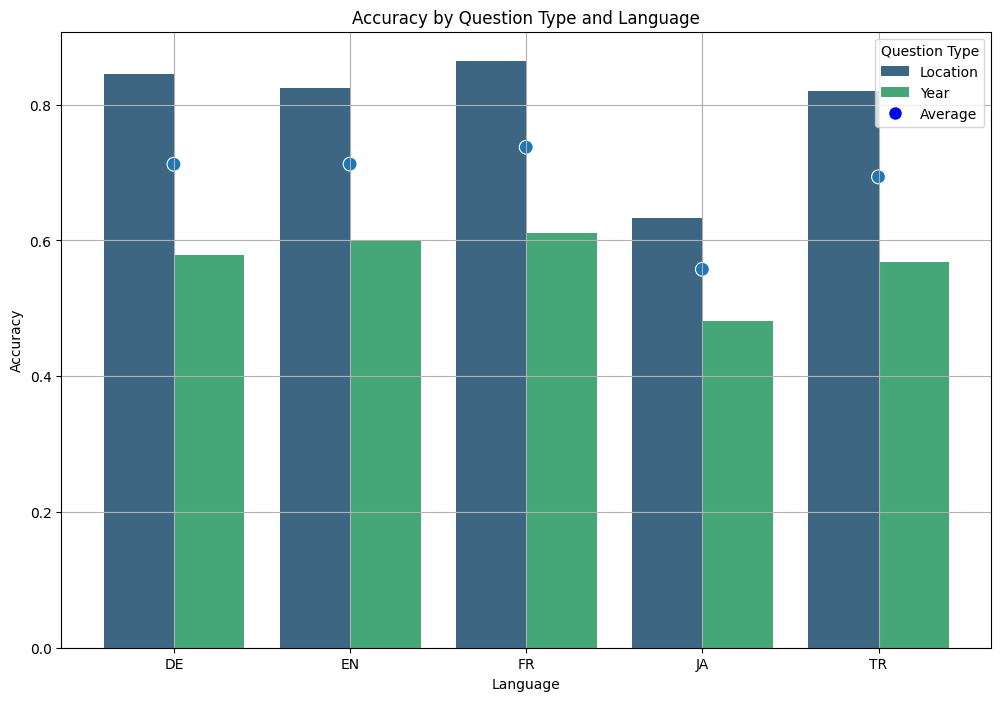

In [29]:
# Calculate the accuracy for each group of question type and language
accuracy_df = combined_df.groupby(['Language', 'question_type'])['Compared_Answer'].value_counts(normalize=True).unstack().fillna(0)
accuracy_df['Accuracy'] = accuracy_df[1]  # Accuracy is the proportion of 1s
accuracy_df = accuracy_df.reset_index()

# Filter only "Location" and "Year" question types
filtered_accuracy_df = accuracy_df[accuracy_df['question_type'].isin(['Location', 'Year'])]

# Calculate the average accuracy for each language
average_accuracy_df = filtered_accuracy_df.groupby('Language')['Accuracy'].mean().reset_index()
average_accuracy_df['question_type'] = 'Average'

# Combine the average accuracy with the filtered accuracy data
combined_accuracy_df = pd.concat([filtered_accuracy_df, average_accuracy_df], ignore_index=True)

# Plot the accuracies
plt.figure(figsize=(12, 8))

# Bar plot for Location and Year questions
sns.barplot(x='Language', y='Accuracy', hue='question_type', data=filtered_accuracy_df, palette='viridis')

# Scatter plot for Average accuracy
sns.scatterplot(x='Language', y='Accuracy', hue='question_type', style='question_type', data=average_accuracy_df, markers=['o'], s=100, color='blue', legend=False)

# Add a custom legend for the average dots
handles, labels = plt.gca().get_legend_handles_labels()
handles.append(plt.Line2D([0], [0], marker='o', color='w', label='Average', markersize=10, markerfacecolor='blue'))
labels.append('Average')

plt.legend(handles=handles, title='Question Type')
plt.xlabel('Language')
plt.ylabel('Accuracy')
plt.title('Accuracy by Question Type and Language')
plt.grid(True)
plt.show()

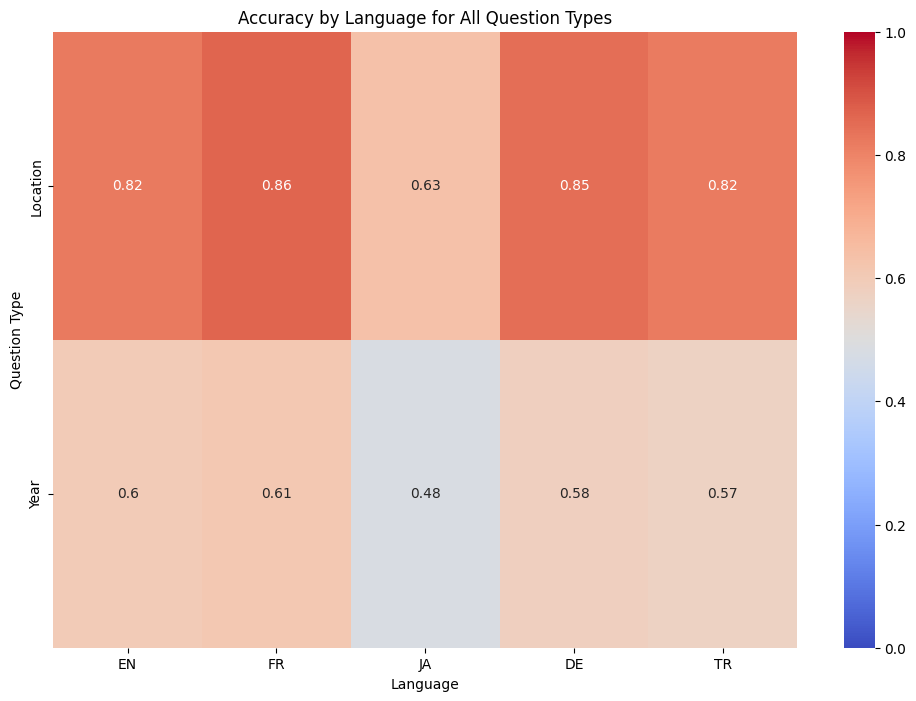

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define the order for groups and languages
language_order = ['EN', 'FR', 'JA', 'DE', 'TR']

# Calculate the accuracy for each group of question type and language
accuracy_df = combined_df.groupby(['question_type', 'Language'])['Compared_Answer'].value_counts(normalize=True).unstack().fillna(0)
accuracy_df['Accuracy'] = accuracy_df[1]  # Accuracy is the proportion of 1s
accuracy_df = accuracy_df.reset_index()

# Filter only "Location" and "Year" question types
filtered_accuracy_df = accuracy_df[accuracy_df['question_type'].isin(['Location', 'Year'])]

# Create a pivot table for the heat map
pivot_df = filtered_accuracy_df.pivot_table(index='question_type', columns='Language', values='Accuracy')

# Reorder the languages in the pivot table
pivot_df = pivot_df[language_order]

# Plot a combined heatmap for all question types
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_df, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.xlabel('Language')
plt.ylabel('Question Type')
plt.title('Accuracy by Language for All Question Types')
plt.show()
